In [1]:
from cvx.stat_arb.ccp import *
from backtest import run_finding_backtest
from utils import *
import seaborn as sns

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
prices_full = pd.read_csv("../data/stock_prices.csv", index_col=0, parse_dates=True)
market_cap = pd.read_csv("../data/market_cap.csv", index_col=0, parse_dates=True)
spreads = pd.read_csv("../data/spreads_stocks.csv", index_col=0, parse_dates=True)
spreads = spreads.rolling(5).mean().ffill().fillna(10 * (0.01**2)).abs()

In [3]:
results, portfolios = run_finding_backtest(
    prices_full,
    market_cap,
    P_max=50,
    moving_midpoint=False,
    midpoint_memory=None,
    T_max=63,
)

8% 16% 24% 32% 40% 48% 56% 64% 72% 80% 88% 96% 
Finished after looking for stat-arbs 127 times


Total number of (potential) SAs found: 1270
Average number of assets per SA: 6.0
Median number of assets per SA: 6.0
Total number of validated SAs: 539
max: 11
min: 2


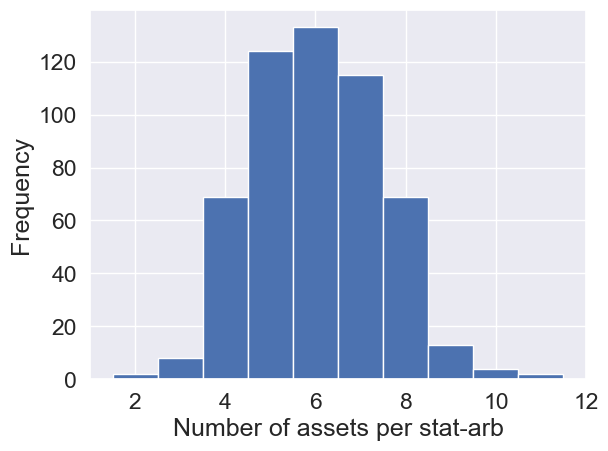

In [4]:
### How many assets per SA on average
lens = []
n_stat_arbs = 0

for res in results:
    stat_arb = res.stat_arb
    lens.append(stat_arb.stocks.shape[0])
    n_stat_arbs += 1

iterations = 127  # XXX number of iterations printed in previous cell
K = 10
print(f"Total number of (potential) SAs found: {iterations*K}")
print(f"Average number of assets per SA: {np.mean(lens):.1f}")
print(f"Median number of assets per SA: {np.median(lens):.1f}")
print(f"Total number of validated SAs: {n_stat_arbs}")
print(f"max: {np.max(lens)}")
print(f"min: {np.min(lens)}")
plt.hist(lens, bins=np.arange(1.5, 12.5, 1))
plt.xlabel("Number of assets per stat-arb")
plt.ylabel("Frequency");

# Analyze results

### Simulate stat-arb portfolios to compute metrics

In [5]:
all_traded_assets = []

for portfolio in portfolios:
    all_traded_assets += portfolio.units.columns.tolist()
all_traded_assets = list(set(all_traded_assets))

means = []
stdevs = []
sharpes = []
profits = []
min_navs = []
min_cum_profs = []
drawdowns = []

n_busts = 0

for i, portfolio in enumerate(portfolios):
    res = results[i]

    (
        mean,
        stdev,
        sharpe,
        mean_profit,
        min_nav,
        min_cum_prof,
        drawdown,
        went_bust,
    ) = simulate(res, portfolio, spreads[all_traded_assets], lev_fraction=0.5)

    means.append(mean)
    stdevs.append(stdev)
    sharpes.append(sharpe)
    profits.append(mean_profit)
    min_navs.append(min_nav)
    min_cum_profs.append(min_cum_prof)
    drawdowns.append(drawdown)

    n_busts += went_bust

stat_arb_metrics = pd.DataFrame(
    {
        "means": means,
        "stdevs": stdevs,
        "sharpes": sharpes,
        "profits": profits,
        "min_navs": min_navs,
        "min_cum_prof": min_cum_prof,
        "drawdowns": drawdowns,
    }
)


Portfolio exited early at 2018-12-24 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2018-12-21 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2019-06-13 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2019-04-30 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-01-14 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-02-04 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-03-18 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-03-18 00:00:00
Long positions + cash fell below short position

Portfolio exited early at 2020-03-12 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-03-16 00:00:00
Long positions + cash fell below short position

Portfolio exited early at 2020-06-18 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2020-07-06 00:00:00
NAV fell below 0.5 * cash

Portfolio exited early at 2021-02-16 00:00:00
NAV fell below 0.5 * cash

Portfo

In [6]:
print(f"Number of busts: {n_busts}")

Number of busts: 17


In [8]:
avg_lens = np.mean(lens)
median_len = np.median(lens)
n_unique_stat_arbs = n_stat_arbs

means = stat_arb_metrics.means
stdevs = stat_arb_metrics.stdevs
sharpes = stat_arb_metrics.sharpes
profits = stat_arb_metrics.profits
min_navs = stat_arb_metrics.min_navs
min_cum_prof = stat_arb_metrics.min_cum_prof
drawdowns = stat_arb_metrics.drawdowns

print(f"Average number of assets per SA: {avg_lens:.1f}")
print(f"Median number of assets per SA: {median_len:.1f}")
print(f"Number of unique SAs: {n_unique_stat_arbs}")
print(f"Mean profit: {profits.mean():.2f}")
print(f"Median profit: {profits.median():.2f}")
print(f"Std profit: {profits.std():.2f}")
print(f"75th percentile: {profits.quantile(0.75):.2f}")
print(f"25th percentile: {profits.quantile(0.25):.2f}")
print(f"Fraction profitable: {(profits > 0).mean():.2f}")
print(f"Average minimum cumulative profit: {min_cum_prof.mean():.2f}")

print("\nMean return")
print(f"Mean return: {means.mean():.2f}")
print(f"Median return: {means.median():.2f}")
print(f"75th percentile return: {means.quantile(0.75):.2f}")
print(f"25th percentile return: {means.quantile(0.25):.2f}")
print(f"Fraction positive: {(means > 0).mean():.2f}")


print("\nRisk")
print(f"Mean risk: {stdevs.mean():.2f}")
print(f"Median risk: {stdevs.median():.2f}")
# print(f"Std risk: {stdevs.std():.2f}")
print(f"75th percentile risk: {stdevs.quantile(0.75):.2f}")
print(f"25th percentile risk: {stdevs.quantile(0.25):.2f}")

print("\nSharpe")
print(f"Average Sharpe: {sharpes.mean():.2f}")
print(f"Median Sharpe: {sharpes.median():.2f}")
# print(f"Std Sharpe: {sharpes.std():.2f}")
print(f"75th percentile Sharpe: {sharpes.quantile(0.75):.2f}")
print(f"25th percentile Sharpe: {sharpes.quantile(0.25):.2f}")
print(f"Fraction positive: {(sharpes > 0).mean():.2f}")

print("\nDrawdown")
print(f"Mean drawdown: {drawdowns.mean():.2f}")
print(f"Median drawdown: {drawdowns.median():.2f}")
# print(f"Std drawdown: {drawdowns.std():.2f}")
print(f"75th percentile drawdown: {drawdowns.quantile(0.75):.2f}")
print(f"25th percentile drawdown: {drawdowns.quantile(0.25):.2f}")

Average number of assets per SA: 6.0
Median number of assets per SA: 6.0
Number of unique SAs: 539
Mean profit: 0.19
Median profit: 0.75
Std profit: 3.03
75th percentile: 1.64
25th percentile: -0.41
Fraction profitable: 0.68
Average minimum cumulative profit: -0.00

Mean return
Mean return: 0.02
Median return: 0.18
75th percentile return: 0.34
25th percentile return: -0.05
Fraction positive: 0.71

Risk
Mean risk: 0.35
Median risk: 0.21
75th percentile risk: 0.38
25th percentile risk: 0.13

Sharpe
Average Sharpe: 0.81
Median Sharpe: 1.01
75th percentile Sharpe: 1.86
25th percentile Sharpe: -0.21
Fraction positive: 0.71

Drawdown
Mean drawdown: 0.17
Median drawdown: 0.10
75th percentile drawdown: 0.19
25th percentile drawdown: 0.05


### Number of active stat-arbs over time

Average number of active stat arbs: 16.33
Median number of active stat arbs: 16.00
Maximum number of active stat arbs: 30.00
Minimum number of active stat arbs: 1.00


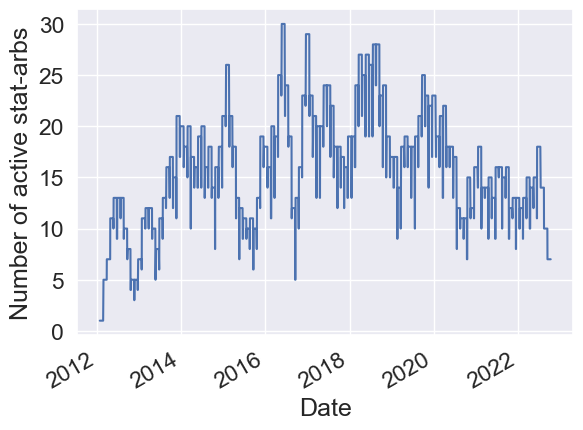

In [9]:
times = prices_full.index
n_active = pd.Series(index=times, data=0)

for res in results:
    entry_date = res.metrics.entry_date
    exit_date = res.metrics.exit_date

    n_active.loc[entry_date:exit_date] += 1
    n_active.loc[
        exit_date
    ] -= 1  # to account for the fact that the last day is not active

n_active = n_active[n_active > 0]

n_active.plot()
plt.ylabel("Number of active stat-arbs")
plt.xlabel("Date")

print(f"Average number of active stat arbs: {n_active.mean():.2f}")
print(f"Median number of active stat arbs: {n_active.median():.2f}")
print(f"Maximum number of active stat arbs: {n_active.max():.2f}")
print(f"Minimum number of active stat arbs: {n_active.min():.2f}")

### Example stat-arbs

In [14]:
quantile_low = 0.235
quantile_high = 0.7
quantiles = means.quantile([quantile_low, quantile_high])

TARGET CORP, Retail Trade
VANGUARD INTL EQUITY INDEX FUNDS, Finance and Insurance
DEUTSCHE BANK A G, Finance and Insurance
SCHWAB CHARLES CORP NEW, Finance and Insurance
DELTA AIR LINES INC, Transportation and Warehousing
ALEXION PHARMACEUTICALS INC, Professional, Scientific, and Technical Services
ARCHER DANIELS MIDLAND CO, Manufacturing
stat-arb:  3.4×49154+9.0×91130+4.0×89199+5.2×75186-1.1×91926+0.5×83111-3.1×10516


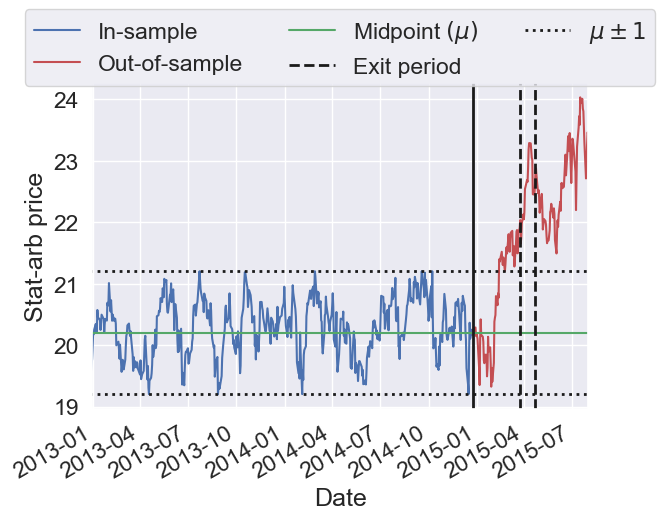

<Figure size 500x500 with 0 Axes>

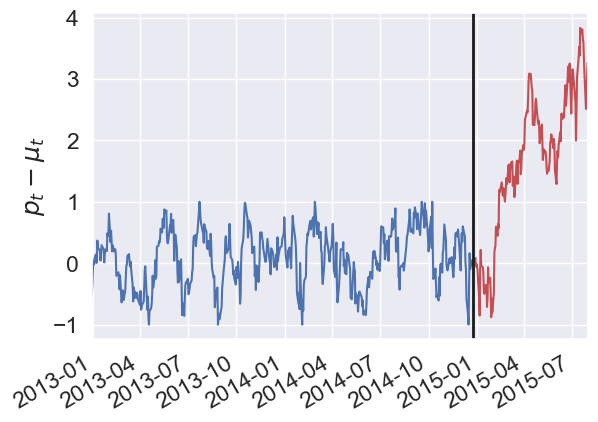

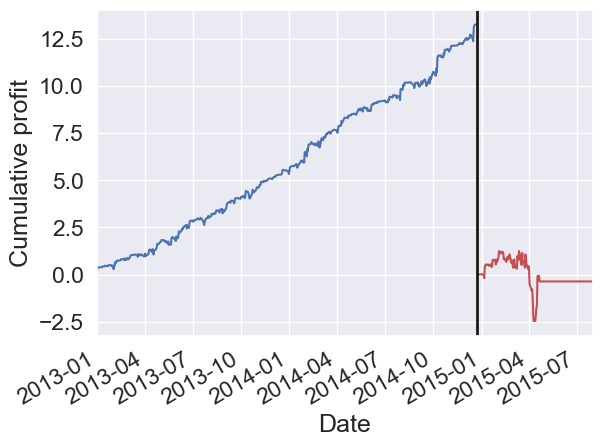

In [16]:
res_low = results[means[(means - quantiles[quantile_low]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_low, insample_bound=1, outsample_bound=np.inf, spreads=spreads);

AMGEN INC, Manufacturing
WALGREEN CO, Retail Trade
ANADARKO PETROLEUM CORP, Mining, Quarrying, and Oil and Gas Extraction
YUM BRANDS INC, Accommodation and Food Services
ENERGY TRANSFER EQUITY L P, Utilities
ALEXION PHARMACEUTICALS INC, Professional, Scientific, and Technical Services
stat-arb:  1.4×14008-1.7×19502+3.5×70332+2.5×85348-1.6×91111+0.9×83111


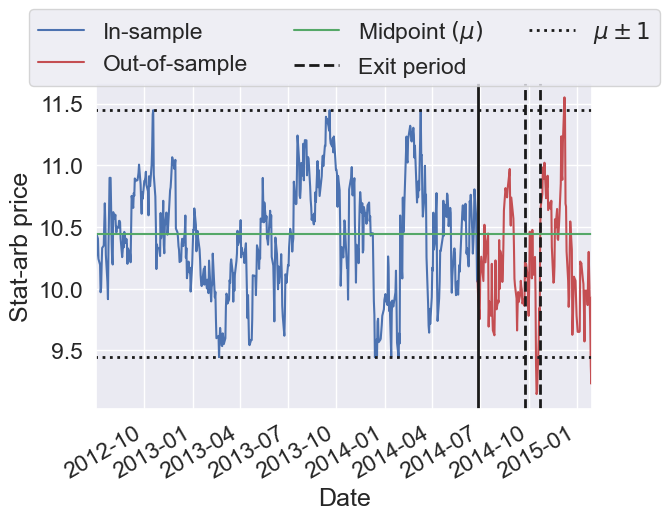

<Figure size 500x500 with 0 Axes>

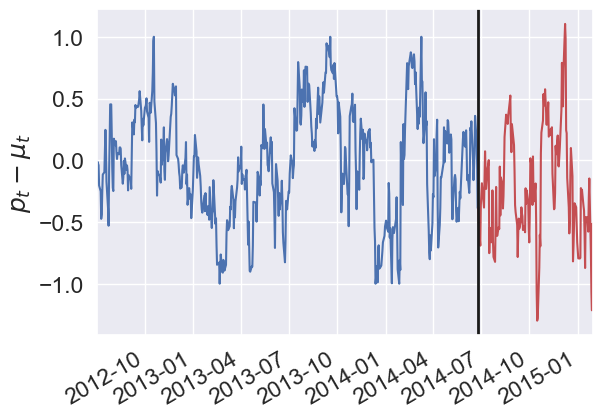

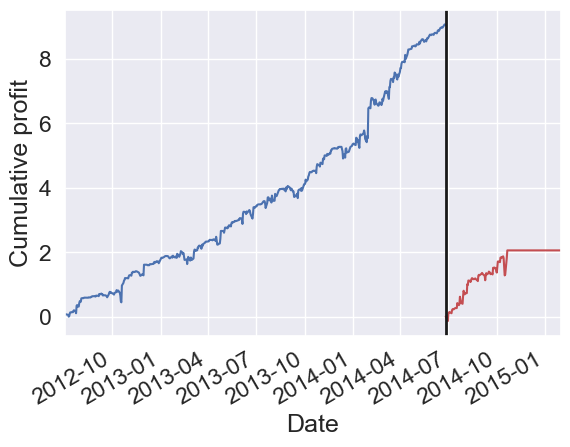

In [13]:
res_high = results[
    means[(means - quantiles[quantile_high]).abs().argsort()[:1]].index[0]
]
plot_stat_arb(res_high, insample_bound=1, outsample_bound=np.inf, spreads=spreads);